In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas.api.types import CategoricalDtype
import seaborn as sns

%load_ext tensorboard
import datetime

from tensorflow.keras.utils import to_categorical

filename = "../../Datasets/Haberman/haberman.csv"

df = pd.read_csv(filename,encoding = 'utf-8',header = None)
df.head()

,0,1,2,3
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [2]:
df.columns.tolist()
df.rename(columns = {0:'op_age',1:'op_yr',2:'num_axnodes',3:'class_val'},inplace = True)
df.head(1)
df['class_val'].value_counts()

1    225
2     81
Name: class_val, dtype: int64

In [3]:
# Create category types.
#class_type = CategoricalDtype(['Type1','Type2','Type3'], ordered=True)

# Convert all categorical values to category type.
#df.class_val = df.class_val.astype(class_type)

In [4]:
# Convert categories into integers for each column.
df.class_val=df.class_val.replace({1:0, 2:1})

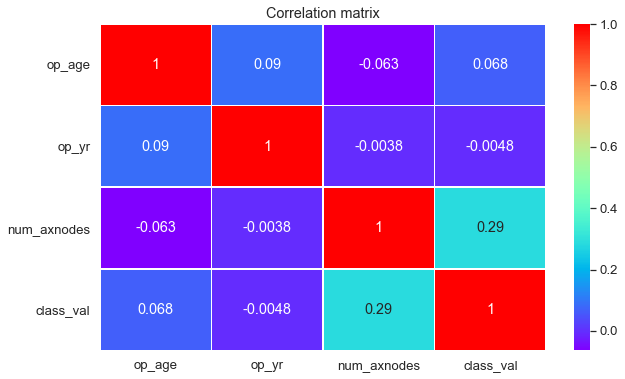

In [5]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(),annot=True, cmap='rainbow',linewidth=0.5)
plt.title('Correlation matrix');

In [6]:
# Choose attribute columns and class column.
X=df[df.columns[:-1]]
y=df['class_val']

y = np.array(y)
y = to_categorical(y)
df.head()

,op_age,op_yr,num_axnodes,class_val
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0


In [7]:
initializer0 = keras.initializers.RandomUniform(minval = 2, maxval =2)
initializer1 = keras.initializers.RandomUniform(minval = -2, maxval =2)
initializer2 = keras.initializers.RandomUniform(minval = -2, maxval =2)

class Diffact(keras.layers.Layer):
    def __init__(self):
        super(Diffact, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

from keras import backend as K

class Mish(keras.layers.Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

Using TensorFlow backend.


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
# split data into train, test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=69, shuffle=True)
#kipping y since value already 1 or 0
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
'''
# normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled)
'''
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print (df.columns)

(275, 3) (275, 2)
(31, 3) (31, 2)
Index(['op_age', 'op_yr', 'num_axnodes', 'class_val'], dtype='object')


In [9]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(10, input_dim=3, activation='selu'))
#diffact=Diffact()
#model.add(Mish())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [10]:
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(amsgrad=True), metrics=["accuracy"])

log_dir = "logs/fit21/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1 ,callbacks=[tensorboard_callback], verbose=1)


Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 37.0502 - accuracy: 0.6000WARNING:tensorflow:From C:\Users\shamb\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 0s 6ms/step - loss: 18.6465 - accuracy: 0.6964 - val_loss: 22.4625 - val_accuracy: 0.6071
Epoch 2/100
50/50 [==============================] - 0s 1ms/step - loss: 14.3868 - accuracy: 0.6761 - val_loss: 12.8020 - val_accuracy: 0.6071
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 7.9347 - accuracy: 0.6680 - val_loss: 4.5220 - val_accuracy: 0.5714
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 5.4005 - accuracy: 0.5830 - val_loss: 3.5164 - val_accuracy: 0.5000
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - 

50/50 [==============================] - 0s 858us/step - loss: 0.6144 - accuracy: 0.7045 - val_loss: 0.7777 - val_accuracy: 0.6429
Epoch 55/100
50/50 [==============================] - 0s 818us/step - loss: 0.6223 - accuracy: 0.7247 - val_loss: 0.8023 - val_accuracy: 0.6429
Epoch 56/100
50/50 [==============================] - 0s 798us/step - loss: 0.5327 - accuracy: 0.7814 - val_loss: 0.7883 - val_accuracy: 0.6429
Epoch 57/100
50/50 [==============================] - 0s 818us/step - loss: 0.5888 - accuracy: 0.7571 - val_loss: 0.7551 - val_accuracy: 0.6429
Epoch 58/100
50/50 [==============================] - 0s 878us/step - loss: 0.5784 - accuracy: 0.7206 - val_loss: 0.7283 - val_accuracy: 0.6429
Epoch 59/100
50/50 [==============================] - 0s 977us/step - loss: 0.5703 - accuracy: 0.7409 - val_loss: 0.7632 - val_accuracy: 0.6429
Epoch 60/100
50/50 [==============================] - 0s 858us/step - loss: 0.6100 - accuracy: 0.7409 - val_loss: 0.7469 - val_accuracy: 0.6429
Epoch

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4429928660392761
Test accuracy: 0.8387096524238586


In [12]:
#print("AF coefficients (weights) {}".format(diffact.get_weights()))

In [16]:
%tensorboard --logdir logs/fit21 --port=6041

Reusing TensorBoard on port 6041 (pid 10948), started 0:02:07 ago. (Use '!kill 10948' to kill it.)

In [14]:
df.describe()

,op_age,op_yr,num_axnodes,class_val
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,0.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,0.000000
25%,44.000000,60.000000,0.000000,0.000000
50%,52.000000,63.000000,1.000000,0.000000
75%,60.750000,65.750000,4.000000,1.000000
max,83.000000,69.000000,52.000000,1.000000
